In [1753]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

import requests
import time
import re    

from selenium import webdriver
from selenium.webdriver.common.keys import Keys


import os

from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import KFold
import ml_insights as mli



pd.set_option('display.max_columns', None)
%matplotlib inline

### Scraping Box Office Mojo for movie 1 and movie 2 of a franchise

In [913]:
# Ping Movie Franchise page and scrape info if responsive
response = requests.get("http://www.boxofficemojo.com/franchises/?view=Franchise&sort=name&order=ASC&p=.htm")
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "lxml")
else:
    print('Bad response; status_code: %d' %response.status_code)

In [914]:
# Find the table
franchise_table = soup.find_all("table")
franchises = franchise_table[3] # multiple entries, the main table is in the 3rd

In [915]:
# Pull links from the table
franchise_links = []
for row in franchises.findAll("tr"):
    link = row.find("a")
    franchise_links.append(link["href"])

In [916]:
# Drop the first row because it's a header
franchise_links = franchise_links[1:]

In [920]:
# initialize storage dfs and header
header = ['Rank','Title','Studio','Adjusted Gross','Unadjusted Gross', 'Release', 'Link']
original_films = pd.DataFrame(columns = header)
sequel_films = pd.DataFrame(columns = header)

# Ping each franchise page and scrape table if responsive
for franchise in franchise_links:
    currlink = 'http://www.boxofficemojo.com/franchises' + franchise[1:]
    response = requests.get(currlink)
    
    # ping and soupify if responsive
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "lxml")
    else:
        print('Bad response; status_code: %d' %response.status_code) 
    
    # find the table
    movie_franchise_table_all = soup.find_all("table")
    movie_franchise_table = movie_franchise_table_all[5] # multiple entries, the main table is in the 5th
    
    # scrape table data
    movie_franchise_data = []
    for row in movie_franchise_table("tr"):
        row_dict={}
        for i,cell in enumerate(row.findAll("td")):
            row_dict[header[i]] = cell.find(text=True)
            link = row.find("a")
            if link:
                row_dict['Title'] = link.text
                row_dict['Link'] = link["href"]
        movie_franchise_data.append(row_dict) 
        
    # convert to a df and make dates a datetime object
    movie_franchise_df = pd.DataFrame(movie_franchise_data)
    movie_franchise_df['Release']=pd.to_datetime(movie_franchise_df['Release'], errors='coerce')
    sorted_by_date_franchise = movie_franchise_df.sort_values('Release')
    
    # Don't include ('REISSUE')-ed movies
    sorted_by_date_franchise= sorted_by_date_franchise[~sorted_by_date_franchise.Title.str.contains('(Re-issue)', case=False)]
    
    # interested in storing only the two oldest films (i.e. film 1 and its sequel)
    original_films = original_films.append(sorted_by_date_franchise.iloc[0], ignore_index=True)
    sequel_films = sequel_films.append(sorted_by_date_franchise.iloc[1], ignore_index=True)
    
    # log file to keep track of scraping progress
    with open('ErrorLog.txt','a') as efile:
        efile.write('\nFinished movie link: {}'.format(currlink))
   

/Users/James/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [921]:
# Delete entries that only had statistics for only one movie (sequels to be released soon)
original_films_clean = original_films[~sequel_films['Release'].isnull()]
sequel_films_clean = sequel_films[~sequel_films['Release'].isnull()]

### Scraping Box Office Mojo for inflation adjustment table over the years

In [306]:
# Ping Movie Franchise page and scrape info if responsive
response = requests.get("http://www.boxofficemojo.com/about/adjuster.htm")
if response.status_code == 200:
    soup_adjust = BeautifulSoup(response.text, "lxml")
else:
    print('Bad response; status_code: %d' %response.status_code)

In [307]:
# Find the table
adjust_table = soup_adjust.find_all("table")
adjust = adjust_table[2] # multiple entries, the main table is in the 2nd

In [342]:
conversion_array = []
# Scrape the table and add to dictionary
for row in adjust("tr"):
    conversion_dict = {}
    for i,cell in enumerate(row.findAll("td")):
        print(i)
        conversion_dict[i] = cell.find(text=True)
    conversion_array.append(conversion_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


In [505]:
conversion_df = pd.DataFrame(conversion_array[3:])
conversion_df =conversion_df.rename(columns={0: 'Year_str', 1: 'Value'})

In [506]:
# Strip $ and make float
conversion_df.iloc[0][1] = 8.65
conversion_df.iloc[:,1]=conversion_df.iloc[:, 1].replace('[\$,]', '', regex=True).astype(float)

# Set years as datetime and as index
conversion_df['Year_dt']=pd.to_datetime(conversion_df['Year_str'], errors='coerce')
conversion_df['Year'] = conversion_df['Year_dt'].map(lambda x: x.year)
conversion_df=conversion_df.set_index('Year', drop=True)

### Scraping IMDB for budget, genre, and ratings

In [644]:
chromedriver = "./chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
driver.get("http://www.imdb.com")


In [1804]:
movie_data = []
headers = ['movie title', 'budget','imbd rating', 'genre', 'director', 'stars']

def do_movie_search(driver, chromedriver):
#        driver.find_element_by_id("navbar-query").clear()
        try:
            navbar =driver.find_element_by_id("navbar-query").clear()
        except:
            driver.close()
            driver = webdriver.Chrome(chromedriver)
            driver.get("http://www.imdb.com") 
        driver.find_element_by_id("navbar-query").clear()
        query = driver.find_element_by_id("navbar-query")
        search_input = str(original_films_clean.iloc[i].Title)
        query.send_keys(search_input)
        query.send_keys(Keys.RETURN)
        div = driver.find_element_by_class_name('findTitleSubfilterList')
        div.find_element_by_css_selector('a').click()
        
        
def selenium_scrape_imdb(original_films_clean):
    
    chromedriver = "./chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    driver.get("http://www.imdb.com")
    
    for i in range(35, len(original_films_clean.Title)):
#     for i in range(len(original_films_clean.Title)):
        # get the search bar
        query = driver.find_element_by_id("navbar-query")
        # search by move title plus the year it was made
        movie_year = original_films_clean.iloc[i].Release.year
        search_input = str(original_films_clean.iloc[i].Title) + ' (' + str(movie_year) + ')'
        query.send_keys(search_input)
        query.send_keys(Keys.RETURN)

        div = driver.find_element_by_class_name('findTitleSubfilterList')
        div.find_element_by_css_selector('a').click()
        
        # if no results were found, take out the year and search again
        src = driver.page_source
        no_results_found = re.search(r'No results found', src)
        
        if no_results_found:
            do_movie_search(driver, chromedriver)
        
        # if no image for the top result (implying obscure movie), take out the year and search again
        div_pic = driver.find_element_by_class_name('primary_photo')
        pic = div_pic.find_element_by_css_selector('img')
        no_pic_found = re.search(r'nopicture', pic.get_attribute('src'))
        
        if no_pic_found:
            do_movie_search(driver, chromedriver)

        div2 = driver.find_element_by_class_name('result_text')
        div2.find_element_by_css_selector('a').click()
        
        # soup the page
        soup_page = BeautifulSoup(driver.page_source)

        # get budget or set to NaN if not there
        budget_pre= soup_page.find(text ="Budget:")

        if budget_pre:
            budget = budget_pre.next.strip()
            budget = budget.replace('$','')
            budget = budget.replace(',','')
            if budget.isdigit():
                budget_adjusted = float(budget) / conversion_df.loc[movie_year].Value * conversion_df.loc[2017].Value
            else:
                budget_adjusted = '*' + budget
        else:
            budget_adjusted = np.nan
        
        #get imdb rating
        rating_html = soup_page.find("div", { "class" : "ratingValue" })
        rating_all = rating_html.text.strip()
        rating = float(rating_all.split('/')[0])

        # get genre
        genre_html = soup_page.find("div", { "class" : "subtext" })
        subtext_array= genre_html.text.split('|')
        genre_list = subtext_array[2].split(',')
        genre_list = list(map(lambda x: x.replace("\n",""), genre_list))
        
        # get director
        director_div = soup_page.find("div", { "class" : "credit_summary_item" })
        director_array = re.split("[\n',]", director_div.text)
        director_array = [x.strip() for x in director_array]
        director_array= filter(None, director_array)
        director_array = [w.replace(' (uncredited)', '') for w in director_array]
        director = director_array[1:]
        
        # get stars
        stars_html = soup_page.find(text ="Stars:")
        a = stars_html.findNext('span').findNext('span')
        b = a.findNext('span').findNext('span')
        c = b.findNext('span').findNext('span')
        stars = [a.text, b.text, c.text]

        movie_dict = dict(zip(headers, [original_films_clean.iloc[i].Title,
                                    budget_adjusted,
                                    rating,
                                    genre_list,
                                    director,
                                    stars]))
        print(i)
        print(movie_dict)
        movie_data.append(movie_dict)
    
    driver.close()  
    return movie_data


In [926]:
full_original_movie_data = selenium_scrape_imdb(original_films_clean)

0
{'director': [u'Jon Turteltaub'], 'budget': 13548192.771084337, 'imbd rating': 5.2, 'movie title': u'3 Ninjas', 'stars': [u'Victor Wong', u'Michael Treanor', u'Max Elliott Slade'], 'genre': [u'Action', u' Comedy', u' Family']}
1
{'director': [u'Gary Fleder'], 'budget': 50882352.941176474, 'imbd rating': 6.6, 'movie title': u'Kiss the Girls', 'stars': [u'Morgan Freeman', u'Ashley Judd', u'Cary Elwes'], 'genre': [u'Crime', u' Drama', u' Mystery']}
2
{'director': [u'Ridley Scott'], 'budget': 37908366.53386455, 'imbd rating': 8.5, 'movie title': u'Alien', 'stars': [u'Sigourney Weaver', u'Tom Skerritt', u'John Hurt'], 'genre': [u'Horror', u' Sci-Fi']}
3
{'director': [u'Janice Karman'], 'budget': nan, 'imbd rating': 7.2, 'movie title': u'The Chipmunk Adventure', 'stars': [u'Ross Bagdasarian Jr.', u'Janice Karman', u'Dody Goodman'], 'genre': [u'Animation', u' Adventure', u' Comedy']}
4
{'director': [u'Sam Firstenberg'], 'budget': 2436619.7183098593, 'imbd rating': 5.4, 'movie title': u'Amer

In [932]:
# Ran these with different for-loop criteria,
full_sequel_movie_data_35 = selenium_scrape_imdb(sequel_films_clean)
full_sequel_movie_data_34 = selenium_scrape_imdb(sequel_films_clean)

35
{'director': [u'Zack Snyder'], 'budget': 250000000.0, 'imbd rating': 6.7, 'movie title': u'Batman v Superman: Dawn of Justice', 'stars': [u'Ben Affleck', u'Henry Cavill', u'Amy Adams'], 'genre': [u'Action', u' Adventure', u' Sci-Fi']}
36
{'director': [u'Pierre Coffin', u'Chris Renaud'], 'budget': 80861008.610086098, 'imbd rating': 7.5, 'movie title': u'Despicable Me 2', 'stars': [u'Steve Carell', u'Kristen Wiig', u'Benjamin Bratt'], 'genre': [u'Animation', u' Adventure', u' Comedy']}
37
{'director': [u'Sanjay Gadhvi'], 'budget': u'*INR\xa0350000000', 'imbd rating': 6.4, 'movie title': u'Dhoom 2', 'stars': [u'Abhishek Bachchan', u'Uday Chopra', u'Hrithik Roshan'], 'genre': [u'24 November 2006 (India) ']}
38
{'director': [u'David Bowers'], 'budget': 22906683.480453972, 'imbd rating': 6.6, 'movie title': u'Diary of a Wimpy Kid: Rodrick Rules', 'stars': [u'Zachary Gordon', u'Devon Bostick', u'Robert Capron'], 'genre': [u'Comedy', u' Family']}
39
{'director': [u'Renny Harlin'], 'budget':

In [933]:
full_sequel_movie_data = full_sequel_movie_data_34 + full_sequel_movie_data_35

### Cleaning up the data to match

In [1240]:
# Convert scraped data to dfs
full_original_movie_df = pd.DataFrame(full_original_movie_data)
full_sequel_movie_df = pd.DataFrame(full_sequel_movie_data)

In [1241]:
# Merge the data from movie dojo and IMDB
original_merged = full_original_movie_df.merge(original_films_clean, left_on='movie title', right_on = 'Title')
sequel_merged = full_sequel_movie_df.merge(sequel_films_clean, left_on='movie title', right_on = 'Title')

In [1242]:
# Store a copy of the HP and IM data
hp_1 = original_merged.iloc[64]
hp_2 = sequel_merged.iloc[64]
ironman1 = original_merged.iloc[82]
ironman2 = sequel_merged.iloc[82]

In [1243]:
# HP and IM both show up in duplicates in both data frames, remove all
hpmask1 = (original_merged.Title == "Harry Potter and the Sorcerer's Stone") | (original_merged.Title == "Iron Man")
hpmask2 = (original_merged.Title == "Harry Potter and the Sorcerer's Stone") | (sequel_merged.Title == 'Iron Man 2')
orig_merge_no_hp = original_merged[~hpmask1]
seq_merge_no_hp = sequel_merged[~hpmask2]

/Users/James/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [1244]:
# Add back one copy of HP and IM, and reset index
orig_merge_1_hp = orig_merge_no_hp.append(hp_1)
orig_merg = orig_merge_1_hp.append(ironman1).reset_index()

seq_merge_1_hp= seq_merge_no_hp.append(hp_2)
seq_merg = seq_merge_1_hp.append(ironman2).reset_index()

In [1245]:
# For some reason, Hulk is in sequels but it's not a franchise
seq_merg_no_hulk = seq_merg[~(seq_merg.Title =='The Incredible Hulk')].reset_index()

In [1246]:
# drop the movies that have N/A budgets from both tables
dropna_budget_mask = orig_merg.budget.isnull() | seq_merg_no_hulk.budget.isnull()
original_movie_budgetna = orig_merg[~dropna_budget_mask]
sequel_movies_budgetna = seq_merg_no_hulk[~dropna_budget_mask]

In [1248]:
# Dhoom (2004) budget in INR
original_movie_budgetna[~original_movie_budgetna.budget.apply(lambda x : isinstance(x, float))]

,index,budget,director,genre,imbd rating,movie title,stars,Rank,Title,Studio,Adjusted Gross,Unadjusted Gross,Release,Link
37,37,*INR 200000000,[Sanjay Gadhvi],"[Action, Adventure, Thriller]",6.7,Dhoom,"[Abhishek Bachchan, Uday Chopra, John Abraham]",3,Dhoom,Yash,"$342,300","$245,756",2004-08-27,/movies/?id=dhoom.htm


In [1249]:
# Fix the Dhoom(2004) budget; in 2004 1 USD = 44.9315 INR
dhoom_USD_2004 = float(200000000) / 44.9315
original_movie_budgetna.budget.loc[37] = dhoom_USD_2004 / conversion_df.loc[2004].Value * conversion_df.loc[2017].Value

/Users/James/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


index                                                           37
budget                                                 6.20017e+06
director                                           [Sanjay Gadhvi]
genre                              [Action,  Adventure,  Thriller]
imbd rating                                                    6.7
movie title                                                  Dhoom
stars               [Abhishek Bachchan, Uday Chopra, John Abraham]
Rank                                                             3
Title                                                        Dhoom
Studio                                                        Yash
Adjusted Gross                                            $342,300
Unadjusted Gross                                          $245,756
Release                                        2004-08-27 00:00:00
Link                                         /movies/?id=dhoom.htm
Name: 37, dtype: object

In [1250]:
# Dhoom 2 (2006) budget in INR, Girl Who Played with Fire (2010) in euro
sequel_movies_budgetna[~sequel_movies_budgetna.budget.apply(lambda x : isinstance(x, float))]

,level_0,index,budget,director,genre,imbd rating,movie title,stars,Rank,Title,Studio,Adjusted Gross,Unadjusted Gross,Release,Link
37,37,37,*INR 350000000,[Sanjay Gadhvi],[24 November 2006 (India) ],6.4,Dhoom 2,"[Abhishek Bachchan, Uday Chopra, Hrithik Roshan]",2,Dhoom 2,Yash,"$3,486,400","$2,643,586",2006-11-23,/movies/?id=dhoom2.htm
99,100,105,*€4000000,[Daniel Alfredson],"[Crime, Drama, Mystery]",7.2,The Girl Who Played with Fire,"[Noomi Rapace, Michael Nyqvist, Lena Endre]",2,The Girl Who Played with Fire,MBox,"$8,557,600","$7,638,241",2010-07-09,/movies/?id=girlwhoplayedwithfire.htm


In [1481]:
# Fix the Dhoom 2 (2006) budget; in 2006 1 USD = 45.2849 INR
dhoom_USD_2006 = float(350000000) / 44.9315
sequel_movies_budgetna.budget.loc[37] = dhoom_USD_2006 / conversion_df.loc[2006].Value * conversion_df.loc[2017].Value

# Fix the Girl Who Played with Fire (2010) budget, in 2010 1 USD = 0.781737 euro
girl_USD_2010 = float(4000000) / 0.781737
sequel_movies_budgetna.budget.loc[99] = girl_USD_2010 / conversion_df.loc[2010].Value * conversion_df.loc[2017].Value

/Users/James/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/James/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Creating the feature df and y

In [1482]:
original_movie_budgetna[sequel_movies_budgetna['imbd rating']> 8.5]

,index,budget,director,genre,imbd rating,movie title,stars,Rank,Title,Studio,Adjusted Gross,Unadjusted Gross,Release,Link
34,34,2.02418e+08,[Christopher Nolan],"[Action, Adventure]",8.3,Batman Begins,"[Christian Bale, Michael Caine, Ken Watanabe]",3,Batman Begins,WB,"$277,102,000","$205,343,774",2005-06-15,/movies/?id=batmanbegins.htm
58,58,3.05294e+07,[Francis Ford Coppola],"[Crime, Drama]",9.2,The Godfather,"[Marlon Brando, Al Pacino, James Caan]",1,The Godfather,Par.,"$680,291,600","$133,698,921",1972-03-15,/movies/?id=godfather.htm
62,62,3.4973e+07,[Michael Mann],"[Crime, Horror, Mystery]",7.2,Manhunter,"[William Petersen, Kim Greist, Joan Allen]",5,Manhunter,DEG,"$20,100,000","$8,620,929",1986-08-15,/movies/?id=manhunter.htm
88,96,1.47863e+07,[Ralph Bakshi],"[Animation, Adventure, Fantasy]",6.2,The Lord of the Rings (1978),"[Christopher Guard, William Squire, Michael Sc...",4,The Lord of the Rings (1978),UA,"$112,640,100","$30,471,420",1978-11-15,/movies/?id=lordoftherings78.htm
97,105,1.42129e+08,[Peter Jackson],"[Adventure, Drama, Fantasy]",8.8,The Lord of the Rings: The Fellowship of the Ring,"[Elijah Wood, Ian McKellen, Orlando Bloom]",3,The Lord of the Rings: The Fellowship of the Ring,NL,"$471,163,300","$313,364,114",2001-12-19,/movies/?id=fellowshipofthering.htm
146,154,4.26682e+07,[George Lucas],"[Action, Adventure, Fantasy]",8.7,Star Wars,"[Mark Hamill, Harrison Ford, Carrie Fisher]",1,Star Wars,Fox,"$1,234,649,200","$307,263,857",1977-05-25,/movies/?id=starwars4.htm


In [1326]:
# Time between release of movie 2 and movie 2
time_between = (sequel_movies_budgetna['Release'] - original_movie_budgetna['Release'])
time_between = (time_between / np.timedelta64(1, 'D')).astype(int)

In [1258]:
# Budget of movie 2 / Budget of movie 1
budget_ratio = sequel_movies_budgetna.budget.div(original_movie_budgetna.budget)

In [1280]:
star_in_sequel = [s1 in s2 for s1, s2 in zip(original_movie_budgetna.stars.str[0], sequel_movies_budgetna.stars)]

In [1285]:
same_director = [s1 in s2 for s1, s2 in zip(original_movie_budgetna.director.str[0], sequel_movies_budgetna.director)]

In [1221]:
# Create a feature df
featuredf = pd.DataFrame(columns = ['movie-1', 'movie-2', 'time', 'budget-ratio', 'movie-1-rating', 'same-lead', 'same-director'])

In [1327]:
# Fill in the columns
featuredf['movie-1'] = original_movie_budgetna.Title
featuredf['movie-2'] = sequel_movies_budgetna.Title
featuredf['time'] = time_between
featuredf['budget-ratio'] = budget_ratio
featuredf['movie-1-rating'] = original_movie_budgetna['imbd rating']
featuredf['same-lead'] = star_in_sequel
featuredf['same-director'] = same_director

In [1328]:
features = featuredf.loc[:, ['time', 'budget-ratio', 'movie-1-rating', 'same-lead', 'same-director']]

In [1409]:
# Strip genre elements
original_movie_budgetna.genre=original_movie_budgetna.genre.map(lambda x: [y.strip() for y in x])

In [1419]:
# Make boolean table for genre categories
genre=pd.get_dummies(original_movie_budgetna.genre.apply(pd.Series).stack()).sum(level=0)
all_features = pd.concat([features, genre], axis=1)

In [1696]:
y = sequel_movies_budgetna['imbd rating']

In [1777]:
pairplot = pd.concat([y, features], axis=1)

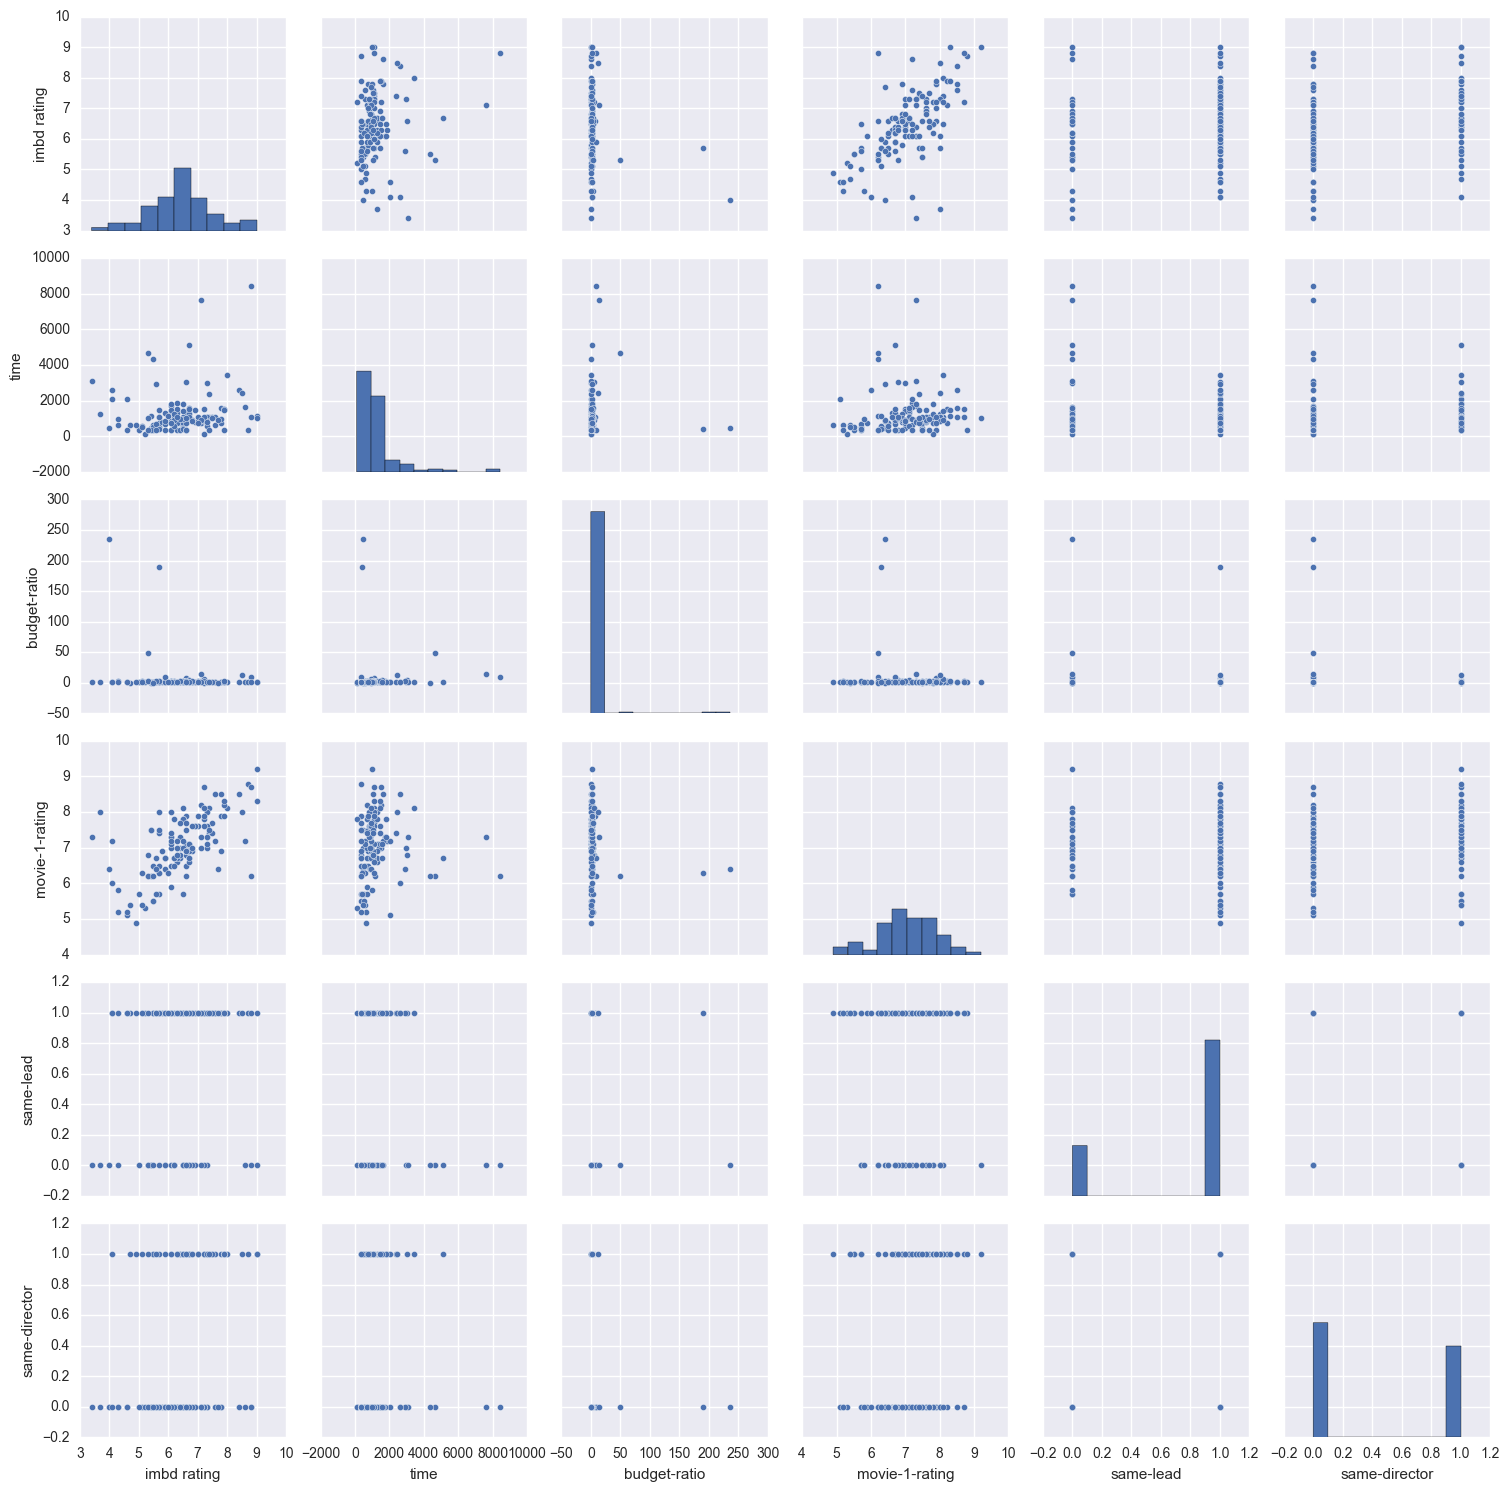

In [1778]:
sns.pairplot(pairplot)

In [1714]:
features[features['movie-1-rating'] >9]

,time,budget-ratio,movie-1-rating,same-lead,same-director
58,1002,1.9697,9.2,False,True


In [1729]:
len(all_features)

135

In [1684]:
sequel_movies_budgetna.loc[sequel_movies_budgetna['imbd rating'] <4.5]

,level_0,index,budget,director,genre,imbd rating,movie title,stars,Rank,Title,Studio,Adjusted Gross,Unadjusted Gross,Release,Link
0,0,0,4.13876e+07,[Charles T. Kanganis],"[Family, Comedy, Action]",4.3,3 Ninjas Kick Back,"[Victor Wong, Max Elliott Slade, Sean Fox]",2,3 Ninjas Kick Back,TriS,"$24,416,300","$11,798,854",1994-05-06,/movies/?id=3ninjaskickback.htm
22,22,22,2.40724e+07,[Joe Berlinger],"[Adventure, Fantasy, Horror]",4.0,Book of Shadows: Blair Witch 2,"[Jeffrey Donovan, Stephen Barker Turner, Erica...",2,Book of Shadows: Blair Witch 2,Art.,"$42,426,900","$26,437,094",2000-10-27,/movies/?id=blairwitch2.htm
42,42,42,2.72554e+07,[Troy Miller],[Comedy],3.4,Dumb and Dumberer: When Harry Met Lloyd,"[Derek Richardson, Eric Christian Olsen, Eugen...",3,Dumb and Dumberer: When Harry Met Lloyd,NL,"$37,693,400","$26,276,465",2003-06-13,/movies/?id=dumbanddumberer.htm
47,47,47,5.43049e+07,[John Boorman],[Horror],3.7,Exorcist II: The Heretic,"[Richard Burton, Linda Blair, Louise Fletcher]",2,Exorcist II: The Heretic,WB,"$119,273,600","$30,749,142",1977-06-17,/movies/?id=exorcist2.htm
66,66,70,6.1639e+07,[Russell Mulcahy],"[Action, Adventure, Fantasy]",4.1,Highlander 2: The Quickening,"[Christopher Lambert, Sean Connery, Virginia M...",1,Highlander 2: The Quickening,Istr,"$31,962,600","$15,556,340",1991-11-01,/movies/?id=highlander2.htm
159,160,165,7.6624e+07,[Mic Rodgers],"[Action, Sci-Fi]",4.1,Universal Soldier: The Return,"[Jean-Claude Van Damme, Bill Goldberg, Heidi S...",2,Universal Soldier: The Return,Sony,"$18,164,800","$10,667,893",1999-08-20,/movies/?id=universalsoldierthereturn.htm
167,168,173,8.09672e+07,[Lee Tamahori],"[Action, Adventure, Crime]",4.3,XXX: State of the Union,"[Ice Cube, Samuel L. Jackson, Willem Dafoe]",2,XXX: State of the Union,SonR,"$36,265,100","$26,873,932",2005-04-29,/movies/?id=xxx2.htm


## Exploration of data

In [1672]:
# Split and CV your data
X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size=0.3)
kf = KFold(len(all_features),n_folds=3, shuffle=True)

### Vanilla Linear Regression

In [1503]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1504]:
lr_model.score(X_test, y_test)

0.36749371140010501

In [1505]:
train_set_pred = lr_model.predict(X_train)
test_set_pred = lr_model.predict(X_test)

In [1506]:
np.sqrt(np.mean((test_set_pred - y_test)**2))

0.94965987610837199

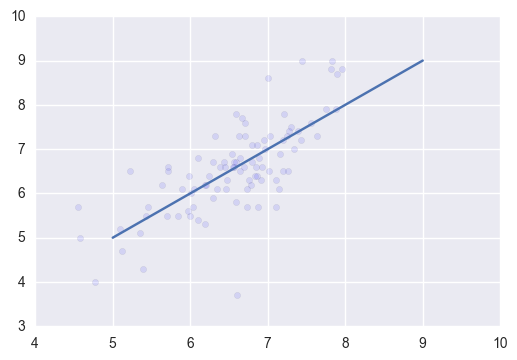

In [1507]:
plt.scatter(train_set_pred,y_train,alpha=.1)
plt.plot(np.linspace(5,9,1000),np.linspace(5,9,1000))

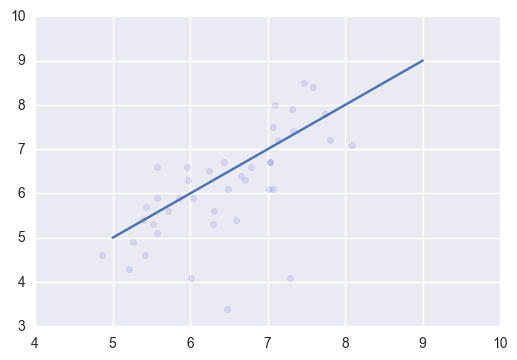

In [1508]:
plt.scatter(test_set_pred,y_test,alpha=.1)
plt.plot(np.linspace(5,9,1000),np.linspace(5,9,1000))

### CV Linear Regression

In [1674]:
lr_cv = LinearRegression()
cvlr_scores = cross_val_score(lr_cv, all_features, y=y, cv = kf, scoring = 'mean_squared_error')
cvlr_scores

array([-0.64536555, -1.31489724, -0.76969337])

In [1675]:
mean_cvlr = np.mean(cvlr_scores)
mean_cvlr

-0.90998538887563285

In [1760]:
cvlr_scores_r = cross_val_score(lr_cv, all_features, y=y, cv = kf)
cvlr_scores_r

array([ 0.55451826, -0.22261824,  0.21729635])

In [1676]:
y_pred_cfold = cross_val_predict(lr_cv, features, y, cv = 3)

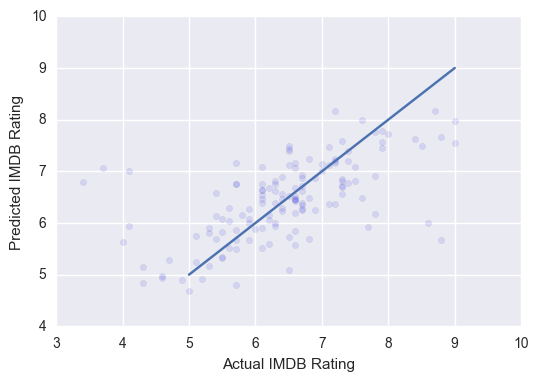

In [1677]:
plt.scatter(y,y_pred_cfold,alpha=.1)
plt.plot(np.linspace(5,9,1000),np.linspace(5,9,1000))
plt.ylabel('Predicted IMDB Rating')
plt.xlabel('Actual IMDB Rating')

In [1846]:
X = all_features.loc[:,'movie-1-rating'].values

In [1849]:
lr_cv2 = LinearRegression()
cvlr_scores2 = cross_val_score(lr_cv, X.reshape(-1, 1), y=y, cv = kf, scoring = 'mean_squared_error')
cvlr_scores2

array([-0.73080376, -0.96577774, -0.50737133])

In [1856]:
np.mean(cross_val_score(lr_cv, X.reshape(-1, 1), y=y, cv = kf))

0.36053159356419617

In [1851]:
np.mean(cvlr_scores2)

-0.73465094508937201

In [1853]:
y_pred_cfold2 = cross_val_predict(lr_cv2, X.reshape(-1,1), y, cv = 3)

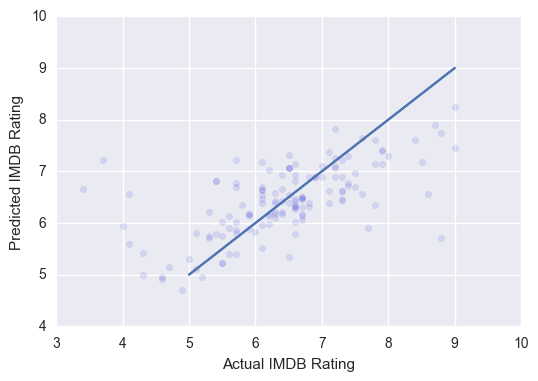

In [1854]:
plt.scatter(y,y_pred_cfold2,alpha=.1)
plt.plot(np.linspace(5,9,1000),np.linspace(5,9,1000))
plt.ylabel('Predicted IMDB Rating')
plt.xlabel('Actual IMDB Rating')

In [1838]:
all_features.head()

,time,budget-ratio,movie-1-rating,same-lead,same-director,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller
0,637,3.05484,5.2,True,False,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1281,1.80212,6.6,True,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2611,1.13783,8.5,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,609,0.317775,5.4,True,True,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,763,2.4478,7.0,True,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### CV Linear Regression + Lasso

In [1581]:
alphavec = 10**np.linspace(-3,9,27)

In [1582]:
lr_model_lasso = LassoCV(alphas = alphavec, cv=3)
lr_model_lasso.fit(all_features,y)
lasso_predict = lr_model_lasso.predict(all_features)

In [1585]:
lasso_scores = cross_val_score(lr_model_lasso, all_features, y=y, cv = kf, scoring = 'mean_squared_error')
lasso_scores

array([-0.88751959, -0.55094702, -1.03700111])

In [1587]:
mean_lasso = np.mean(lasso_scores)
mean_lasso

-0.82515590587235199

In [1761]:
lasso_scores_r = cross_val_score(lr_model_lasso, all_features, y=y, cv = kf)
lasso_scores_r

array([ 0.44232594,  0.10804673,  0.29696927])

In [1738]:
list(zip(all_features.columns,lr_model_lasso.coef_))

[('time', 0.00012222367203862792),
 ('budget-ratio', -0.004532644581555988),
 ('movie-1-rating', 0.69944479247841895),
 ('same-lead', 0.20090661791982115),
 ('same-director', 0.20325820131887531),
 (u'Action', -0.0),
 (u'Adventure', 0.12911203939434368),
 (u'Animation', 0.13870844376394062),
 (u'Comedy', -0.17656753343862092),
 (u'Crime', 0.053354667596308969),
 (u'Drama', 0.0),
 (u'Family', 0.0),
 (u'Fantasy', 0.0),
 (u'Horror', -0.0),
 (u'Music', 0.0),
 (u'Mystery', 0.067616870960854961),
 (u'Romance', -0.0),
 (u'Sci-Fi', 0.020038692779138705),
 (u'Sport', 0.0),
 (u'Thriller', -0.042715738388707604)]

In [1520]:
np.sqrt(np.mean((lasso_predict - y)**2))

0.76728151980857007

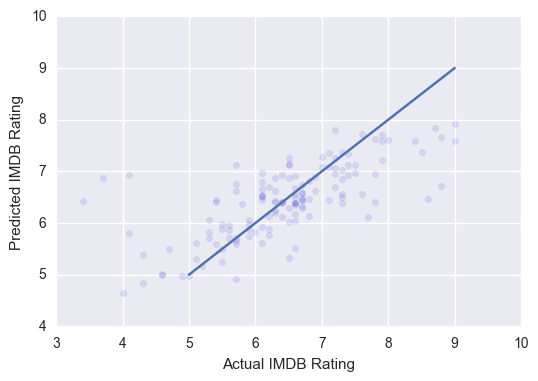

In [1655]:
plt.scatter(y,lasso_predict,alpha=.1)
plt.plot(np.linspace(5,9,1000),np.linspace(5,9,1000))
plt.ylabel('Predicted IMDB Rating')
plt.xlabel('Actual IMDB Rating')

### CV with Random Forest

In [1610]:
rfmodel = RandomForestRegressor(n_estimators = 500, min_samples_leaf=1, n_jobs=-1, max_features = 8) 

In [1611]:
# n_estimators_range = range(500,1000, 100)
min_samples_leaf_range = range(1, 5)
max_features_range = range(3, len(all_features.columns))

In [1612]:
param_grid = dict(max_features= max_features_range, min_samples_leaf =min_samples_leaf_range)

In [1594]:
param_grid = dict(n_estimators = n_estimators_range, min_samples_leaf =min_samples_leaf_range, max_features= max_features_range)

In [1613]:
grid = GridSearchCV(rfmodel, param_grid, cv=3, scoring='mean_squared_error')

In [1614]:
grid.fit(all_features, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [1615]:
print(grid.best_score_)
print(grid.best_params_) 

-0.740607107823
{'max_features': 19, 'min_samples_leaf': 3}


In [1616]:
best_rfmodel = RandomForestRegressor(n_estimators = 500, min_samples_leaf=3, n_jobs=-1, max_features = 19) 
#cross_val_score


In [1620]:
rf_pred = grid.predict(all_features)

In [1670]:
rf_scores = cross_val_score(best_rfmodel, all_features, y=y, cv = kf, scoring = 'mean_squared_error')
rf_scores

array([-0.51388306, -0.95673506, -0.93602002])

In [1762]:
rf_scores_r = cross_val_score(best_rfmodel, all_features, y=y, cv = kf)
rf_scores_r

array([ 0.47910006,  0.03745886,  0.32764977])

In [1671]:
mean_rf = np.mean(rf_scores)
mean_rf

-0.8022127161692828

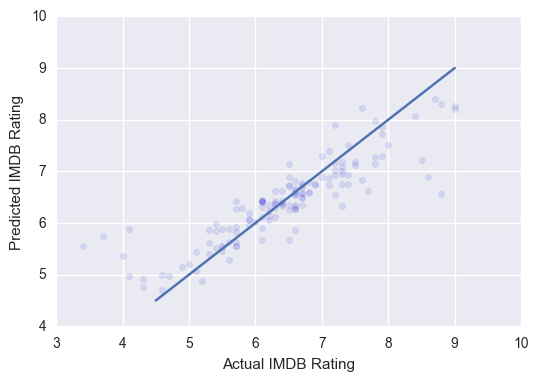

In [1685]:
plt.scatter(y, rf_pred, alpha=.1)
plt.plot(np.linspace(4.5,9,1000),np.linspace(4.5,9,1000))
plt.ylabel('Predicted IMDB Rating')
plt.xlabel('Actual IMDB Rating')

### CV With Gradient Boosting

In [1640]:
gbmodel = GradientBoostingRegressor(n_estimators=500)

In [1646]:
min_samples_leaf_range = range(1, 5)
max_features_range = range(8, len(all_features.columns))
max_depth_range = range(1,5)
learning_rate_range = np.linspace(0.01, 0.5, 10)

In [1647]:
param_grid_gb = dict(max_depth= max_depth_range, min_samples_leaf =min_samples_leaf_range, max_features= max_features_range, learning_rate=learning_rate_range)

In [1648]:
grid_gb = GridSearchCV(gbmodel, param_grid_gb, cv=3, scoring='mean_squared_error')

In [1649]:
grid_gb.fit(all_features, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'learning_rate': array([ 0.01   ,  0.06444,  0.11889,  0.17333,  0.22778,  0.28222,
        0.33667,  0.39111,  0.44556,  0.5    ]), 'max_depth': [1, 2, 3, 4], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [1807]:
print(grid_gb.best_score_)
print(grid_gb.best_params_) 

-0.70604481842
{'max_features': 8, 'learning_rate': 0.064444444444444443, 'max_depth': 1, 'min_samples_leaf': 2}


In [1651]:
best_gbmodel = GradientBoostingRegressor(n_estimators=500, max_features = 8, learning_rate = 0.06444444444444444, max_depth = 1, min_samples_leaf=2)

In [1747]:
best_gb_fit = best_gbmodel.fit(all_features, y)

In [1746]:
gb_pred = grid_gb.predict(all_features)

In [1859]:
gb_pred1 = cross_val_predict(best_gbmodel, all_features, y, cv = 3)

In [1668]:
gb_scores = cross_val_score(best_gbmodel, all_features, y=y, cv = kf, scoring = 'mean_squared_error')
gb_scores

array([-0.59932746, -0.89708583, -0.90178402])

In [1669]:
mean_gb = np.mean(gb_scores)
mean_gb

-0.79939910497183153

In [1769]:
gb_scores_r = cross_val_score(best_gbmodel, all_features, y=y, cv = kf)
gb_scores_r

array([ 0.33943051, -0.18769367, -0.01678028])

In [1837]:
np.mean(gb_scores_r)

0.044985522248084421

In [1781]:
list(zip(all_features.columns,best_gbmodel.feature_importances_))

[('time', 0.214),
 ('budget-ratio', 0.28199999999999997),
 ('movie-1-rating', 0.22),
 ('same-lead', 0.068000000000000005),
 ('same-director', 0.024),
 (u'Action', 0.0),
 (u'Adventure', 0.01),
 (u'Animation', 0.048000000000000001),
 (u'Comedy', 0.02),
 (u'Crime', 0.048000000000000001),
 (u'Drama', 0.002),
 (u'Family', 0.0),
 (u'Fantasy', 0.0),
 (u'Horror', 0.0),
 (u'Music', 0.0),
 (u'Mystery', 0.014),
 (u'Romance', 0.0),
 (u'Sci-Fi', 0.050000000000000003),
 (u'Sport', 0.0),
 (u'Thriller', 0.0)]

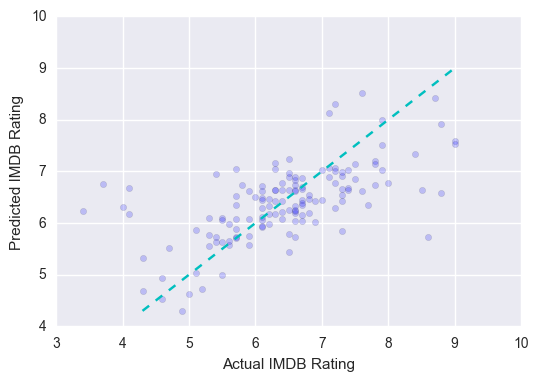

In [1860]:
plt.scatter(y, gb_pred1, alpha=.2)
plt.plot(np.linspace(4.3,9,1000),np.linspace(4.3,9,1000), '--', color='c')
plt.ylabel('Predicted IMDB Rating')
plt.xlabel('Actual IMDB Rating')

### Looking at feature importance

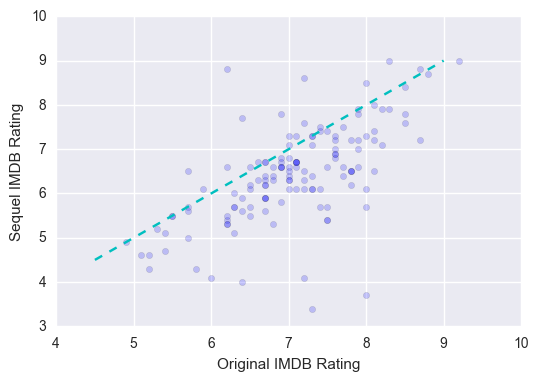

In [1732]:
# Look at relationship between Movie 1 IMDB Rating and Sequel IMDB Rating
plt.scatter(original_movie_budgetna['imbd rating'], sequel_movies_budgetna['imbd rating'], alpha=.2)
plt.plot(np.linspace(4.5,9,1000),np.linspace(4.5,9,1000), '--', color='c')
plt.xlabel('Original IMDB Rating')
plt.ylabel('Sequel IMDB Rating')

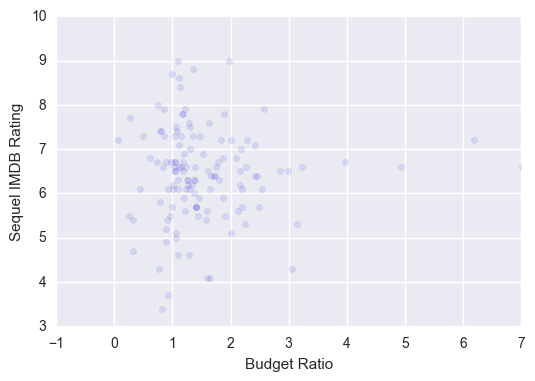

In [1735]:
# Look at relationship between budget ratio and Sequel IMDB Rating

plt.scatter(features['budget-ratio'], sequel_movies_budgetna['imbd rating'], alpha=.1)
plt.xlim(-1, 7)
plt.xlabel('Budget Ratio')
plt.ylabel('Sequel IMDB Rating')

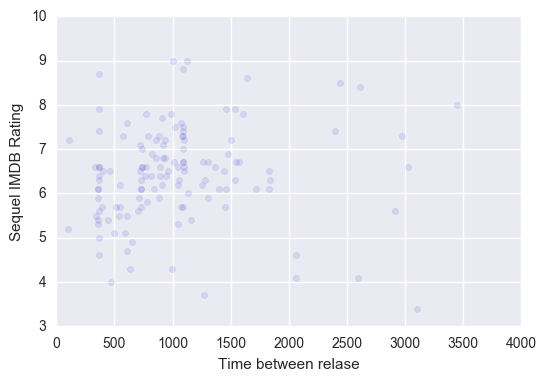

In [1736]:
# Look at relationship between Time and Sequel IMDB Rating
plt.scatter(features['time'], sequel_movies_budgetna['imbd rating'], alpha=.1)
plt.xlim(-1, 4000)
plt.xlabel('Time between release')
plt.ylabel('Sequel IMDB Rating')

In [1748]:
mxr_rf = mli.ModelXRay(best_gb_fit,all_features)

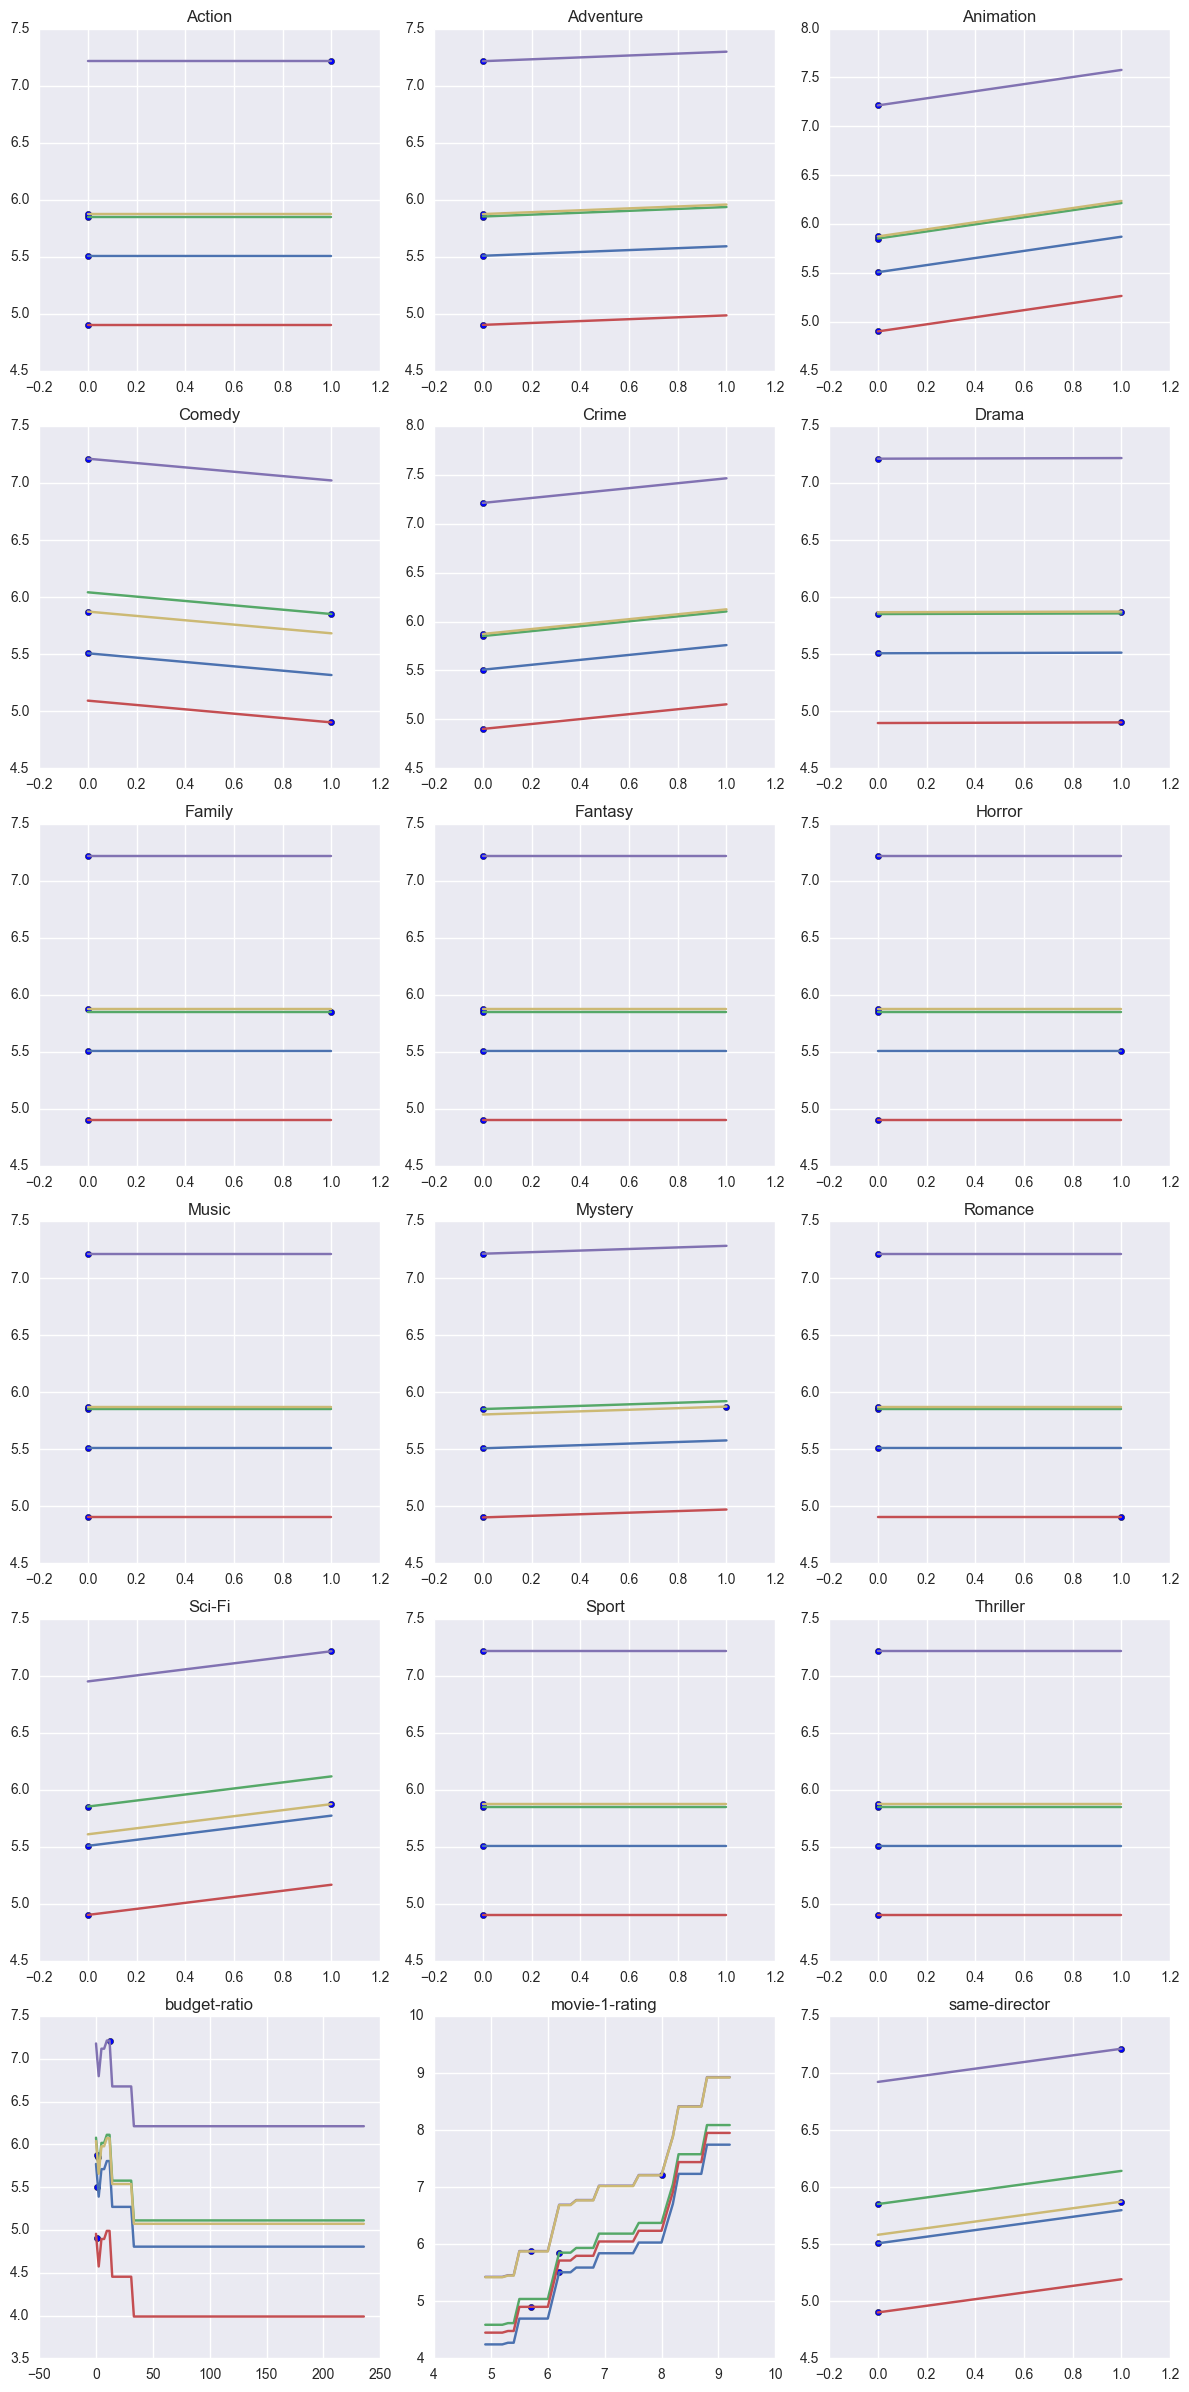

In [1750]:
indices = mxr_rf.feature_dependence_plots(num_pts=5)

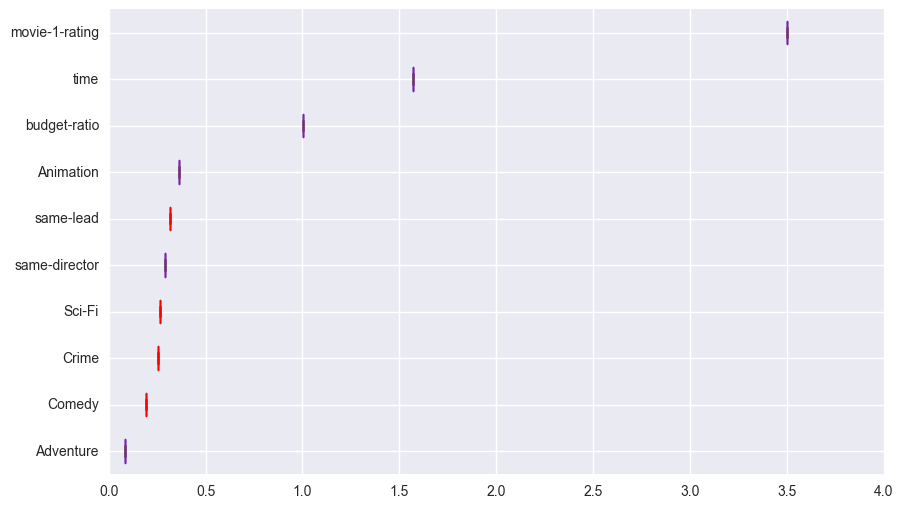

In [1757]:
mxr_rf.feature_effect_summary()

(array([  5.,   8.,   3.,  21.,  30.,  24.,  24.,  13.,   5.,   2.]),
 array([ 4.9 ,  5.33,  5.76,  6.19,  6.62,  7.05,  7.48,  7.91,  8.34,
         8.77,  9.2 ]),
 <a list of 10 Patch objects>)

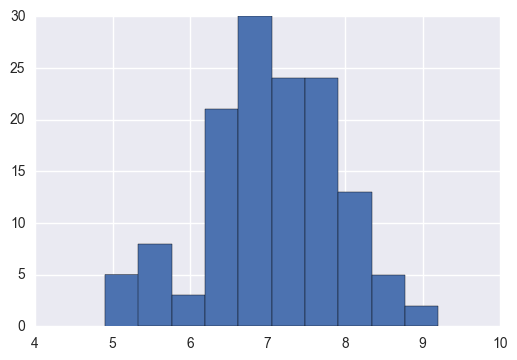

In [1782]:
plt.hist(all_features['movie-1-rating'])

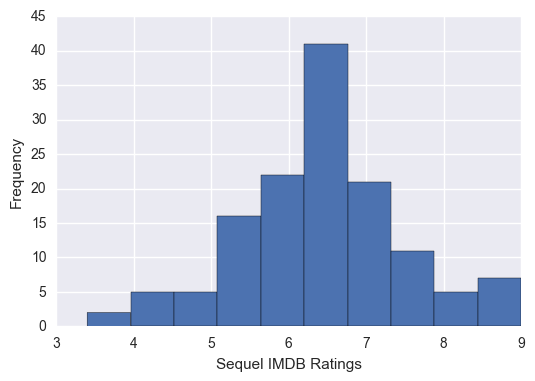

In [1791]:
plt.hist(y)
plt.xlabel('Sequel IMDB Ratings')
plt.ylabel('Frequency')

In [1835]:
# Import data from the-numbers.com
y_num = pd.read_csv('numbers_rating',header=None)

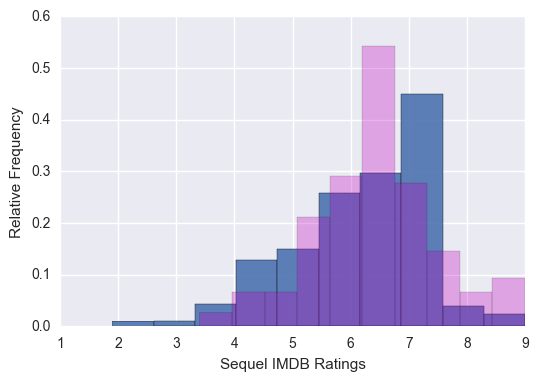

In [1834]:
# Plot hist of the-numbers and boxofficemojo together
plt.hist(y_num[1], normed=True, alpha = 0.9)
plt.hist(y, normed=True, alpha=0.3, color = 'm')
plt.xlabel('Sequel IMDB Ratings')
plt.ylabel('Relative Frequency')

In [1861]:
a = [('time', 0.214),
 ('budget-ratio', 0.28199999999999997),
 ('movie-1-rating', 0.22),
 ('same-lead', 0.068000000000000005),
 ('same-director', 0.024),
 (u'Action', 0.0),
 (u'Adventure', 0.01),
 (u'Animation', 0.048000000000000001),
 (u'Comedy', 0.02),
 (u'Crime', 0.048000000000000001),
 (u'Drama', 0.002),
 (u'Family', 0.0),
 (u'Fantasy', 0.0),
 (u'Horror', 0.0),
 (u'Music', 0.0),
 (u'Mystery', 0.014),
 (u'Romance', 0.0),
 (u'Sci-Fi', 0.050000000000000003),
 (u'Sport', 0.0),
 (u'Thriller', 0.0)]